### <center>Student: *Skorodumov Sergey*</center>

## Description

1. Choose the time period to form the graph
2. Those how are making projects on artilces: half of you need to choose co-authorship graph, others - citation (but consider citation graph as undirected for simplicity)
3. Use weighted graph so that probabilities of infection passing is proportional to the edge weight 

### Data

In [412]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics

data = pd.read_csv('data.csv',usecols=['id_1','id_2','weight'])
max_weight = max(data['weight'])
print('Maximum weight of edge in graph: '+str(max_weight))
G=nx.Graph()
for index, row in data.iterrows():
    G.add_edge(row['id_1'], row['id_2'], weight=row['weight'])

Maximum weight of edge in graph: 13


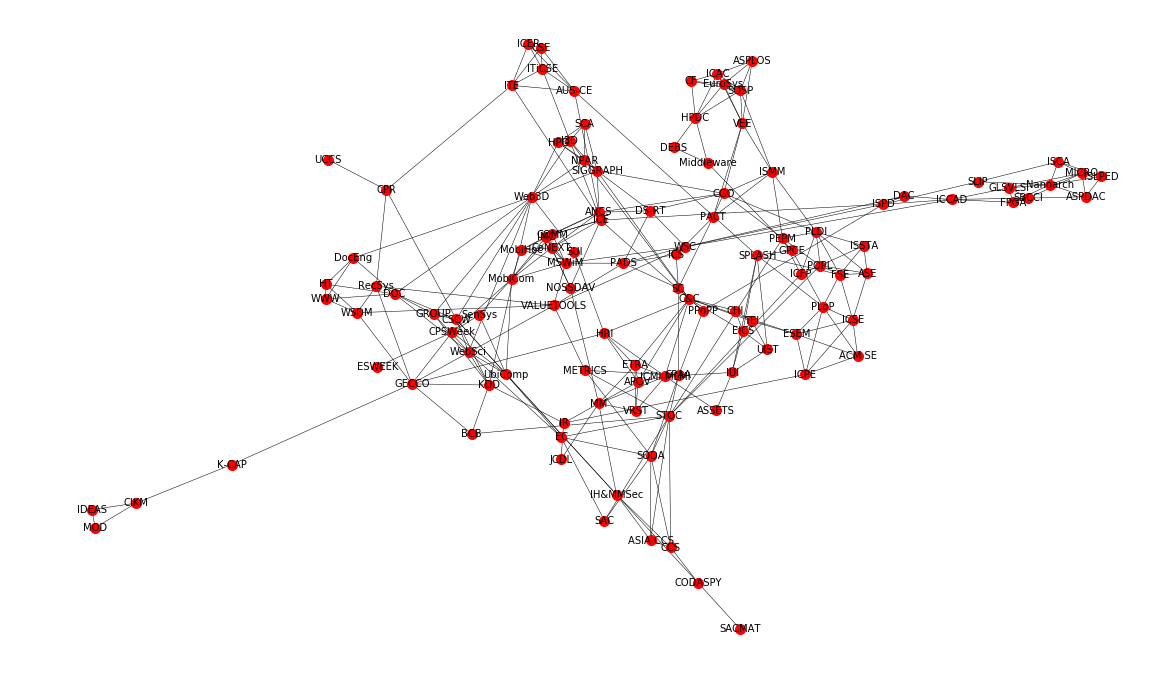

In [73]:
plt.figure(figsize=(20,12))
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=100)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=0.5)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=0.5, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=10,)
plt.axis('off')
plt.show()


### Model

Consider SIR-based epidemic model using idea of percolation

Link to source: http://www.leonidzhukov.net/hse/2015/networks/papers/networks-book-ch21.pdf 

### Task

You are in charge of leading the vaccination campaign against some outbroken nonlethal disease. You have options to vactinate or provide medical treatment to infected ones. However, everything has its costs:
* Vaccination of a node costs $500 \$$ and make it immune to the disease all life-long. Unfortunately, you can help this way only to no more than $10\%$ of your nodes
* Medical Treatment costs $120\$$ per day of illness period, which in turn may take from $3$ to $7$ days

Your task is to implement the simulation model, propose some vaccination strategies and compare them (one iteration = one day).

In [524]:
import random
import math
#number of starting infected nodes 
start_infected = math.floor(len(G)*0.33)

cases_results = []
for case in range(1,5):
    #time
    t = 0
    #costs for vaccination and medical treatment
    costs = 0
    #susceptible
    S = list(G.nodes)
    #infected
    I = []
    #recovered
    R = []
    #treated
    T = []
    #susceptible at time
    S_t = []
    #infected at time
    I_t = []
    #recovered at time
    R_t = []

    #infection probability for weight=1
    p = 1/(max_weight*10)


    start = random.randint(30,40)
    for i in range(0,start):
        infected = S[random.randint(0,len(S)-1)]
        I.append(infected)
        S.remove(infected)

    #case 1
    if (case == 1):
        infected_neighbors_num = []
        vaccinated = 0
        for infected in I:
            infected_neighbors_num.append({
                'node': infected,
                'neighbors_num': len(list(G.neighbors(infected)))
            })

        infected_neighbors_num.sort(key=lambda x: x['neighbors_num'],reverse=True)
        for i in range(min(len(infected_neighbors_num), math.floor(0.1*len(G.nodes)))):
            I.remove(infected_neighbors_num[i]['node'])
            R.append(infected_neighbors_num[i]['node'])
            costs += 500
            vaccinated += 1
        for i in range(len(I)):
            T.append({
                'name': infected_neighbors_num[i+vaccinated]['node'],
                'day': 0
                     })

    #case 2
        if (case == 2):
            for infected in I:
                for neighbor in G.neighbors(infected):
                    if (neighbor not in S):
                        continue
                    w = G.get_edge_data(infected,neighbor)['weight']
                    if (statistics.median(data['weight']) < w):
                        patient = next((x for x in T if x['name'] == infected), None)
                        if (patient not in T):
                            T.append({
                                'name': infected,
                                'day': 0
                            })
    #case 3, 4
    if (case == 3 or case == 4):
        degree_centrality = dict(nx.degree_centrality(G))
        for i in range(min(len(I), math.floor(0.1*len(G.nodes)))):
            while (len(degree_centrality) > 0):
                if (max(degree_centrality) in I):
                    I.remove(max(degree_centrality))
                    R.append(max(degree_centrality))
                degree_centrality.pop(max(degree_centrality))
                break
            costs += 500
        
        for infected in I:
            for neighbor in G.neighbors(infected):
                if (neighbor not in S):
                    continue
                w = G.get_edge_data(infected,neighbor)['weight']
                if (statistics.median(data['weight']) < w):
                    patient = next((x for x in T if x['name'] == infected), None)
                    if (patient not in T):
                        T.append({
                            'name': infected,
                            'day': 0
                        })
    S_t.append(len(S))
    I_t.append(len(I))
    R_t.append(len(R))

    while(1):
        t += 1
        #print('day',t)
        if (len(S) == 0 or len(I) == 0):
            break

        #infection period
        for infected in I:
            new_infected = []
            for neighbor in G.neighbors(infected):
                if (neighbor not in S):
                    continue
                w = G.get_edge_data(infected,neighbor)['weight']
                if (random.random() < w*p):
                    new_infected.append(neighbor)

            #recovering without treatment or Vaccination
            patient = next((x for x in T if x['name'] == infected), None)
            if (patient not in T):
                if (random.random() < 0.01):
                    R.append(infected)
                    I.remove(infected)
                    #print('cured',infected)
        for infected in new_infected:
            I.append(infected)
            S.remove(infected)
            #print(infected,"is infected!")
        #recovering after treatment
        for treating_patient in T:
            costs += 120
            treating_patient['day'] += 1
            if(treating_patient['day'] >= 3):
                if (random.random() < treating_patient['day']/7):
                    I.remove(treating_patient['name'])
                    T.remove(treating_patient)
                    R.append(treating_patient['name'])
                    #print(treating_patient,' is recovered!')

        #case 2
        if (case == 2 or case == 4):
            for infected in I:
                for neighbor in G.neighbors(infected):
                    if (neighbor not in S):
                        continue
                    w = G.get_edge_data(infected,neighbor)['weight']
                    if (statistics.median(data['weight']) < w):
                        patient = next((x for x in T if x['name'] == infected), None)
                        if (patient not in T):
                            T.append({
                                'name': infected,
                                'day': 0
                            })

        #case 1,3
        if (case == 1 or case == 3):
            for infected in I:
                patient = next((x for x in T if x['name'] == infected), None)
                if (patient not in T):
                    T.append({
                        'name': infected,
                        'day': 0
                    })

        S_t.append(len(S))
        I_t.append(len(I))
        R_t.append(len(R))

    print("Case: №",case)
    print(round(len(I)/len(G.nodes)*100,2),'% are infected!')
    print(round(len(R)/len(G.nodes)*100,2),'% are recovered!')
    print(round(len(S)/len(G.nodes)*100,2),'% are susceptible!')
    print('Costs: ', costs)
    print('Days: ', t)
    print()
    result = {
        'S_t': S_t,
        'I_t': I_t,
        'R_t': R_t,
        'costs': costs,
        'days': t
    }
    cases_results.append(result)
    

Case: № 1
0.0 % are infected!
35.71 % are recovered!
64.29 % are susceptible!
Costs:  19060
Days:  17

Case: № 2
0.0 % are infected!
40.18 % are recovered!
59.82 % are susceptible!
Costs:  14160
Days:  534

Case: № 3
0.0 % are infected!
30.36 % are recovered!
69.64 % are susceptible!
Costs:  19300
Days:  14

Case: № 4
0.0 % are infected!
49.11 % are recovered!
50.89 % are susceptible!
Costs:  21820
Days:  542



## Case 1

On step 0 I am vaccinating nodes,that have more neighbors. If there still remain infected nodes, I start medical tratment for them. After that, each day I start medical treatment for new infected nodes.

Costs:  19060
Days:  17


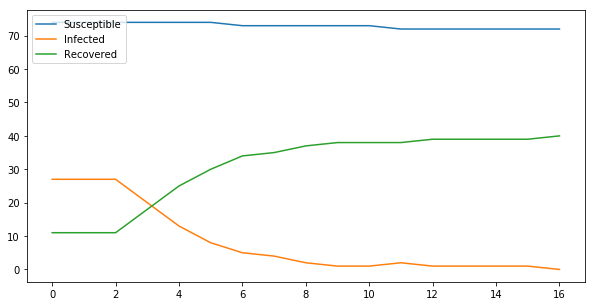

In [525]:
S_t = cases_results[0]['S_t']
I_t = cases_results[0]['I_t']
R_t = cases_results[0]['R_t']
print("Costs: ",cases_results[0]['costs'])
print("Days: ",cases_results[0]['days'])

plt.figure(figsize=(10,5))

plt.plot(list(range(0, len(S_t))), S_t)
plt.plot(list(range(0, len(I_t))), I_t)
plt.plot(list(range(0, len(R_t))), R_t)

plt.legend(['Susceptible', 'Infected', 'Recovered'], loc='upper left')
plt.show()

## Case 2
On step 0 I am vaccinating nodes,that have neighbors with weight of edge,that connects them, greater than mediana of weights of all edges in graph and start medical treatment for remained nodes, that have same issue. Same proccess each day with new infected nodes.

Costs:  14160
Days:  534


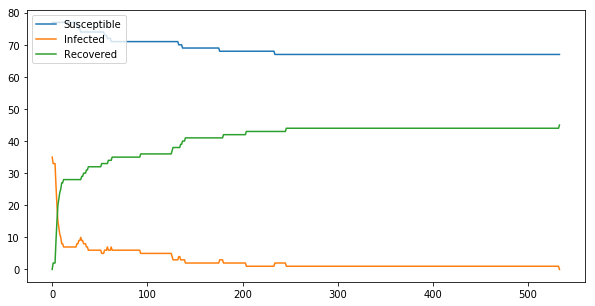

In [526]:
S_t = cases_results[1]['S_t']
I_t = cases_results[1]['I_t']
R_t = cases_results[1]['R_t']
print("Costs: ",cases_results[1]['costs'])
print("Days: ",cases_results[1]['days'])

plt.figure(figsize=(10,5))

plt.plot(list(range(0, len(S_t))), S_t)
plt.plot(list(range(0, len(I_t))), I_t)
plt.plot(list(range(0, len(R_t))), R_t)

plt.legend(['Susceptible', 'Infected', 'Recovered'], loc='upper left')
plt.show()

## Case 3

Similar to case 1, but instead of choosing nodes with the more neighbors, I am vaccinating and starting medical treatment for the rest of them and each day after that for new infected nodes, that have greater centrality degree in graph.

Costs:  19300
Days:  14


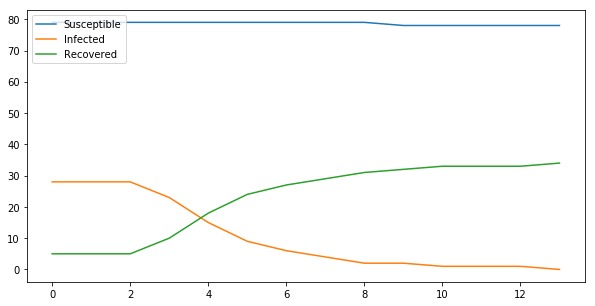

In [527]:
S_t = cases_results[2]['S_t']
I_t = cases_results[2]['I_t']
R_t = cases_results[2]['R_t']
print("Costs: ",cases_results[2]['costs'])
print("Days: ",cases_results[2]['days'])

plt.figure(figsize=(10,5))

plt.plot(list(range(0, len(S_t))), S_t)
plt.plot(list(range(0, len(I_t))), I_t)
plt.plot(list(range(0, len(R_t))), R_t)

plt.legend(['Susceptible', 'Infected', 'Recovered'], loc='upper left')
plt.show()

## Case 4

In this case i have combined cases 2 and 3. First of all, I am vaccinating nodes with greater centrality degree and then, I am starting medical tratment for rest of infected nodes and the fututre ones as in case 2.

Costs:  21820
Days:  542


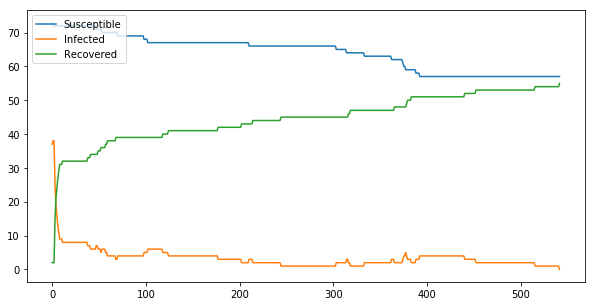

In [528]:
S_t = cases_results[3]['S_t']
I_t = cases_results[3]['I_t']
R_t = cases_results[3]['R_t']
print("Costs: ",cases_results[3]['costs'])
print("Days: ",cases_results[3]['days'])

plt.figure(figsize=(10,5))

plt.plot(list(range(0, len(S_t))), S_t)
plt.plot(list(range(0, len(I_t))), I_t)
plt.plot(list(range(0, len(R_t))), R_t)

plt.legend(['Susceptible', 'Infected', 'Recovered'], loc='upper left')
plt.show()

## Results

Case 2 is the cheapest, while Case 3 is the fastest. The results for Case 1 are about the same as for Case 1(depend on randomness). And the results for Case 4 are the worst.

Cases 1 and 3 work as greed algorithms, they try to cure new patients as soon as possible, because of that they are expensive, but fast.

Case 2 is works with algorithm, that tries to identify nodes,that will infect new nodes with high probability(regarding to mediana). So, nodes that can infect other nodes with low probability will be cured after some time with some probability (In my cases i have included oportunity for nodes to be cured by themselves with some low probability). Because of that, these Case worked a longer time, but with cheaper cost.

Case 4 worked longer,than Case 1 and 3 and with the biggest cost. My expectations were that it will be somewheree in between other Cases, but it turned out, that it didn't work as planned. if we look at statistics, we can see, that 49% were infected, while the other biggest precent of recovered was in Case 2. It means, that in Cases 2 and 4 infection spreads fast,but Case 2 could cope with it with better results.